In [ ]:
import geopandas as gpd
import coincident
import numpy as np
import matplotlib.pyplot as plt
import os 
import glob
import pandas as pd
from scipy import stats
import easysnowdata as esd
from shapely.geometry import box
from tqdm import tqdm
from matplotlib.gridspec import GridSpec
import xarray as xr
import rioxarray as rxr
import matplotlib.lines as mlines


import sys
sys.path.append(os.path.abspath('/home/jehayes/gda_final/ATL06_LaserLottery/misc'))
from nlcd_plot import nlcd_labels, nlcd_colors, hist_nlcd, boxplot_nlcd
from nlcd_sample import sample_nlcd_for_bbox, sample_nlcd_for_points

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Read in summary stats for all of our different parameter combinations from our directory of parquet files that store all the results

In [2]:
# Directory containing your parquet files
dir_path = '/home/jehayes/gda_final/ATL06_LaserLottery/data/OR_McKenzieRiver_1_2021_atl06'
# Use glob to match files that start with "atl06_" and end with ".parquet"
files = glob.glob(os.path.join(dir_path, 'atl06_*.parquet'))
rows = []
for file in files:
    # Extract the basename, e.g., "atl06_30.0_10.0_5_10.0.parquet"
    basename = os.path.basename(file)
    # Remove prefix and suffix to isolate the numeric parameters
    param_str = basename.replace('atl06_', '').replace('.parquet', '')
    # Split the string into its components: len_val, res_val, cnt_val, ats_val
    len_str, res_str, cnt_str, ats_str = param_str.split('_')
    # Convert strings to float (or int if appropriate)
    len_val = float(len_str)
    res_val = float(res_str)
    cnt_val = float(cnt_str)  # Use int(cnt_str) if you prefer an integer
    ats_val = float(ats_str)
    
    # Read the parquet file into a DataFrame
    df = pd.read_parquet(file)
    # Extract the 'elev_diff' column as a NumPy array
    class_data_flat = df['elev_diff'].values
    
    # Compute the desired statistics
    row = {
        "len_val": len_val,
        "res_val": res_val,
        "cnt_val": cnt_val,
        "ats_val": ats_val,
        "Mean": np.mean(class_data_flat),
        "Med": np.median(class_data_flat),
        "Std": np.std(class_data_flat),
        "NMAD": stats.median_abs_deviation(class_data_flat, scale="normal"),
        "Count": len(class_data_flat)
    }
    rows.append(row)

df_grid = pd.DataFrame(rows)

In [3]:
df_grid.sort_values("Med").reset_index(drop=True)

,len_val,res_val,cnt_val,ats_val,Mean,Med,Std,NMAD,Count
0,30.0,10.0,5.0,10.0,7.621827,2.315150,9.916355,3.953032,4677
1,30.0,10.0,10.0,10.0,7.621827,2.315150,9.916355,3.953032,4677
2,30.0,20.0,10.0,5.0,7.621827,2.315150,9.916355,3.953032,4677
3,30.0,20.0,10.0,10.0,7.621827,2.315150,9.916355,3.953032,4677
4,30.0,20.0,5.0,10.0,7.621827,2.315150,9.916355,3.953032,4677
5,30.0,10.0,5.0,5.0,7.621827,2.315150,9.916355,3.953032,4677
6,30.0,20.0,5.0,5.0,7.621827,2.315150,9.916355,3.953032,4677
7,30.0,10.0,10.0,5.0,7.621827,2.315150,9.916355,3.953032,4677
8,40.0,20.0,10.0,10.0,7.611685,2.328093,9.925440,4.018090,4677
9,40.0,10.0,10.0,10.0,7.611685,2.328093,9.925440,4.018090,4677


load in the default ATL06 processing parameters

In [32]:
gf_atl06 = gpd.read_parquet("/home/jehayes/gda_final/ATL06_LaserLottery/data/OR_McKenzieRiver_1_2021_atl06/atl06_40.0_20.0_10_10.0.parquet")
gf_atl06_4326 = gf_atl06.to_crs(4326)

In [5]:
gf_atl06_bbox = gpd.GeoDataFrame(
    geometry=[box(*gf_atl06_4326.buffer(.1).total_bounds)],
    crs=gf_atl06_4326.crs
).to_crs(4326)

/tmp/ipykernel_196514/1449787835.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometry=[box(*gf_atl06_4326.buffer(.1).total_bounds)],


get landcover data and sample

In [6]:
nlcd_landcover = esd.remote_sensing.get_nlcd_landcover(gf_atl06_bbox.iloc[0].geometry, layer='landcover')
da_nlcd = nlcd_landcover.rio.reproject(gf_atl06.crs)

In [34]:
output_dir = "/home/jehayes/gda_final/ATL06_LaserLottery/data/OR_McKenzieRiver_1_2021_gridsearch"
cols = ["h_mean", "dem_elev", "elev_diff", "nlcd_value","nlcd_label", "gt", "cycle", "region", "geometry", "bbox"]
for file in tqdm(files):
    basename = os.path.basename(file)
    fn = basename.replace('atl06', 'nlcd')

    gf_atl06 = gpd.read_parquet(file)
    gf_atl06 = sample_nlcd_for_points(gf_atl06, da_nlcd)
    gf_atl06 = gf_atl06[cols]

    out_path = os.path.join(output_dir, fn)
    gf_atl06.to_parquet(out_path)

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:01<00:00, 15.01it/s]


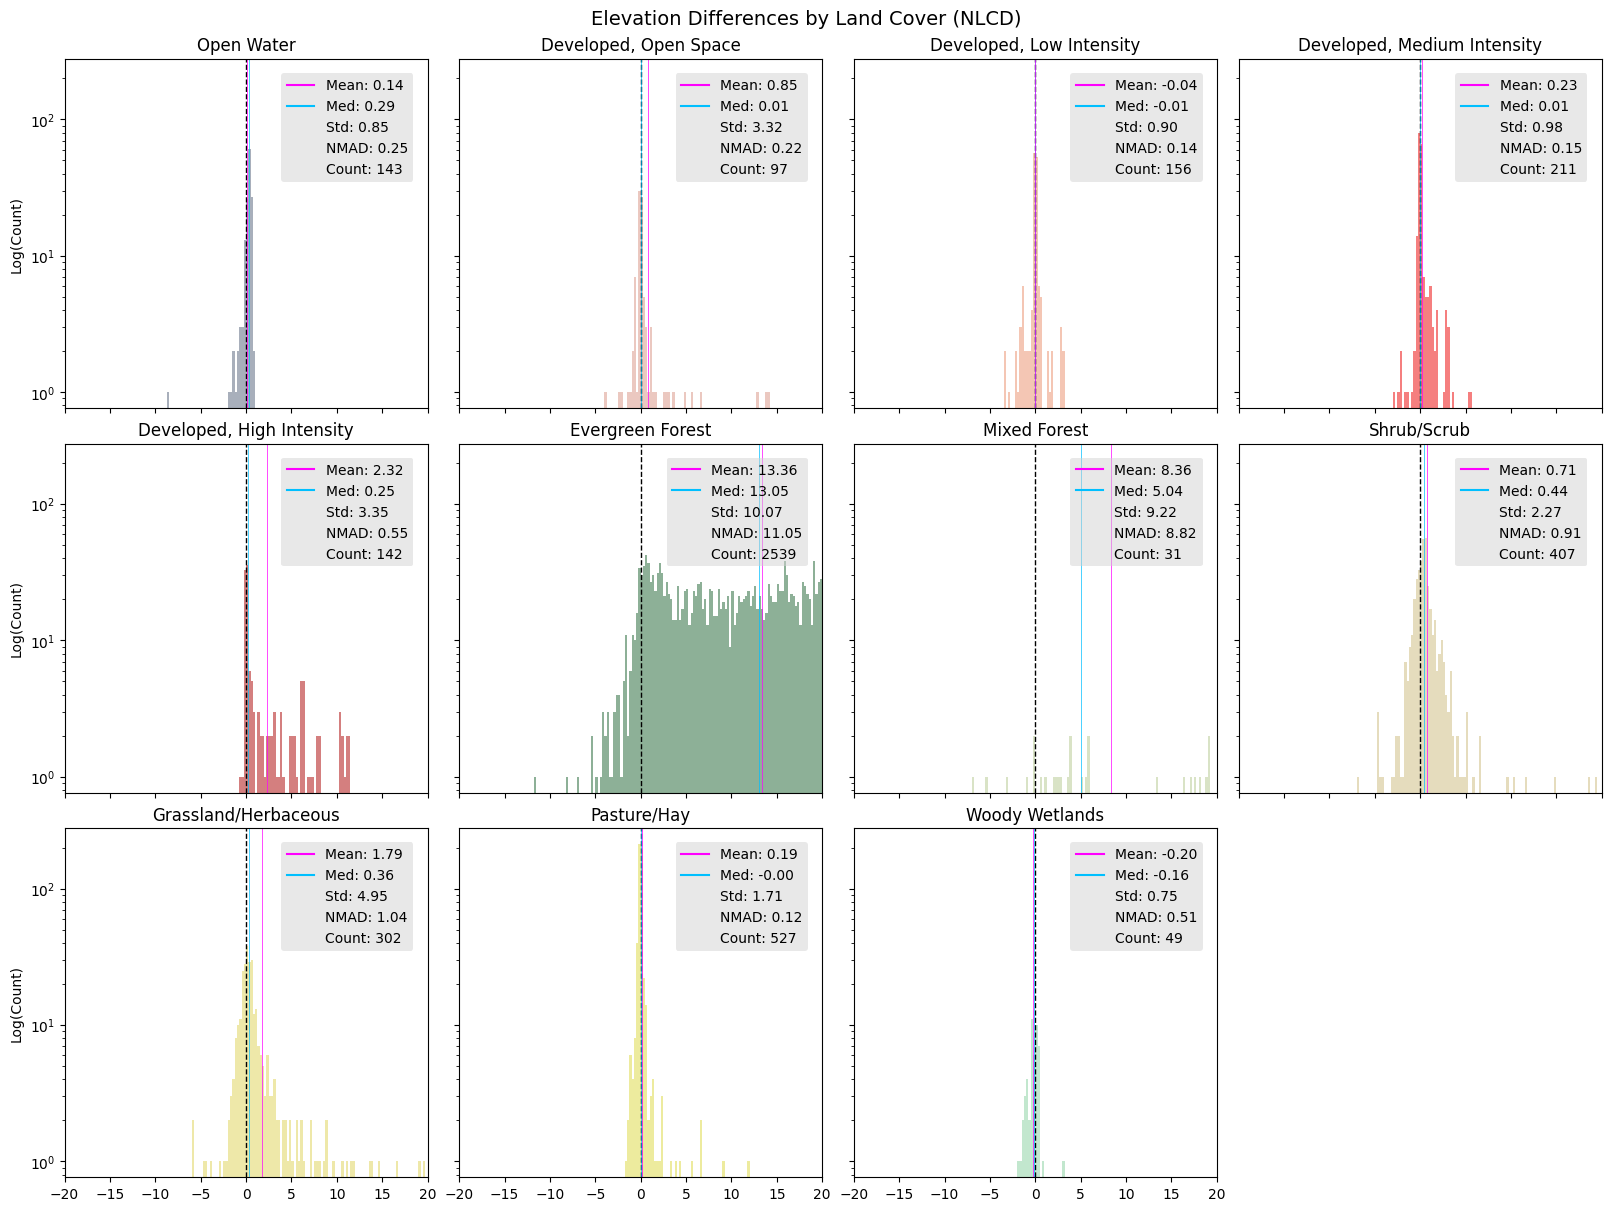

In [ ]:
fig, axes = hist_nlcd(gf_atl06, min_count=30)
plt.show()

get our 3DEP site of interest once again

In [ ]:
gf_flights = gpd.read_file("/home/jehayes/gda_final/ATL06_LaserLottery/test_data/wesm_2021_bboxes_30d_esa.geojson")
aoi = gf_flights.iloc[[0]]
gf_wesm = coincident.search.wesm.load_by_fid(fids=aoi.fid.values).to_crs(gf_atl06.crs)

In [ ]:
gf_atl06

,h_mean,dem_elev,elev_diff,nlcd_value,nlcd_label,gt,cycle,region,geometry,bbox
time,,,,,,,,,,
2021-06-24 00:40:52.051053056,164.890209,165.406036,-0.515828,81.0,Pasture/Hay,60,12,2,POINT (501584.913 4873010.803),"POLYGON ((501604.913 4872990.803, 501604.913 4..."
2021-06-24 00:40:52.053883904,164.678625,164.685547,-0.006922,81.0,Pasture/Hay,60,12,2,POINT (501582.972 4873030.741),"POLYGON ((501602.972 4873010.741, 501602.972 4..."
2021-06-24 00:40:52.073631232,143.744159,144.468018,-0.723858,81.0,Pasture/Hay,60,12,2,POINT (501569.611 4873170.328),"POLYGON ((501589.611 4873150.328, 501589.611 4..."
2021-06-24 00:40:52.076441344,141.829817,141.678284,0.151533,81.0,Pasture/Hay,60,12,2,POINT (501567.717 4873190.271),"POLYGON ((501587.717 4873170.271, 501587.717 4..."
2021-06-24 00:40:52.079252736,139.834421,140.026978,-0.192557,81.0,Pasture/Hay,60,12,2,POINT (501565.819 4873210.213),"POLYGON ((501585.819 4873190.213, 501585.819 4..."
...,...,...,...,...,...,...,...,...,...,...
2021-06-26 12:47:55.340561920,653.892876,634.226074,19.666802,42.0,Evergreen Forest,40,12,6,POINT (522713.256 4903821.611),"POLYGON ((522733.256 4903801.611, 522733.256 4..."
2021-06-26 12:47:55.337753856,644.023377,621.663269,22.360108,42.0,Evergreen Forest,40,12,6,POINT (522715.067 4903841.56),"POLYGON ((522735.067 4903821.56, 522735.067 49..."
2021-06-26 12:47:55.320795136,584.606059,574.339722,10.266337,42.0,Evergreen Forest,40,12,6,POINT (522725.443 4903961.301),"POLYGON ((522745.443 4903941.301, 522745.443 4..."


load in the USGS 3DEP DEM at 10m coarsened resolution

In [ ]:
ds_dem = xr.open_dataset("/mnt/c/Users/JackE/uw/courses/wint25/gda/final_data/dem_10x_itrf.tif", 
                         engine="rasterio").squeeze().rename({'band_data': 'elevation'}).rio.write_crs(gf_atl06.crs).rio.clip([gf_atl06.union_all().envelope])

In [54]:
ds_dem["hillshade"] = coincident.plot.hillshade(ds_dem.elevation)

/home/jehayes/mambaforge/envs/coincident/lib/python3.12/site-packages/coincident/plot/utils.py:102: RuntimeWarning: invalid value encountered in cast
  return da.dims, data.astype(np.uint8)


plot elevation differences for each beam

/tmp/ipykernel_196514/2597918692.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


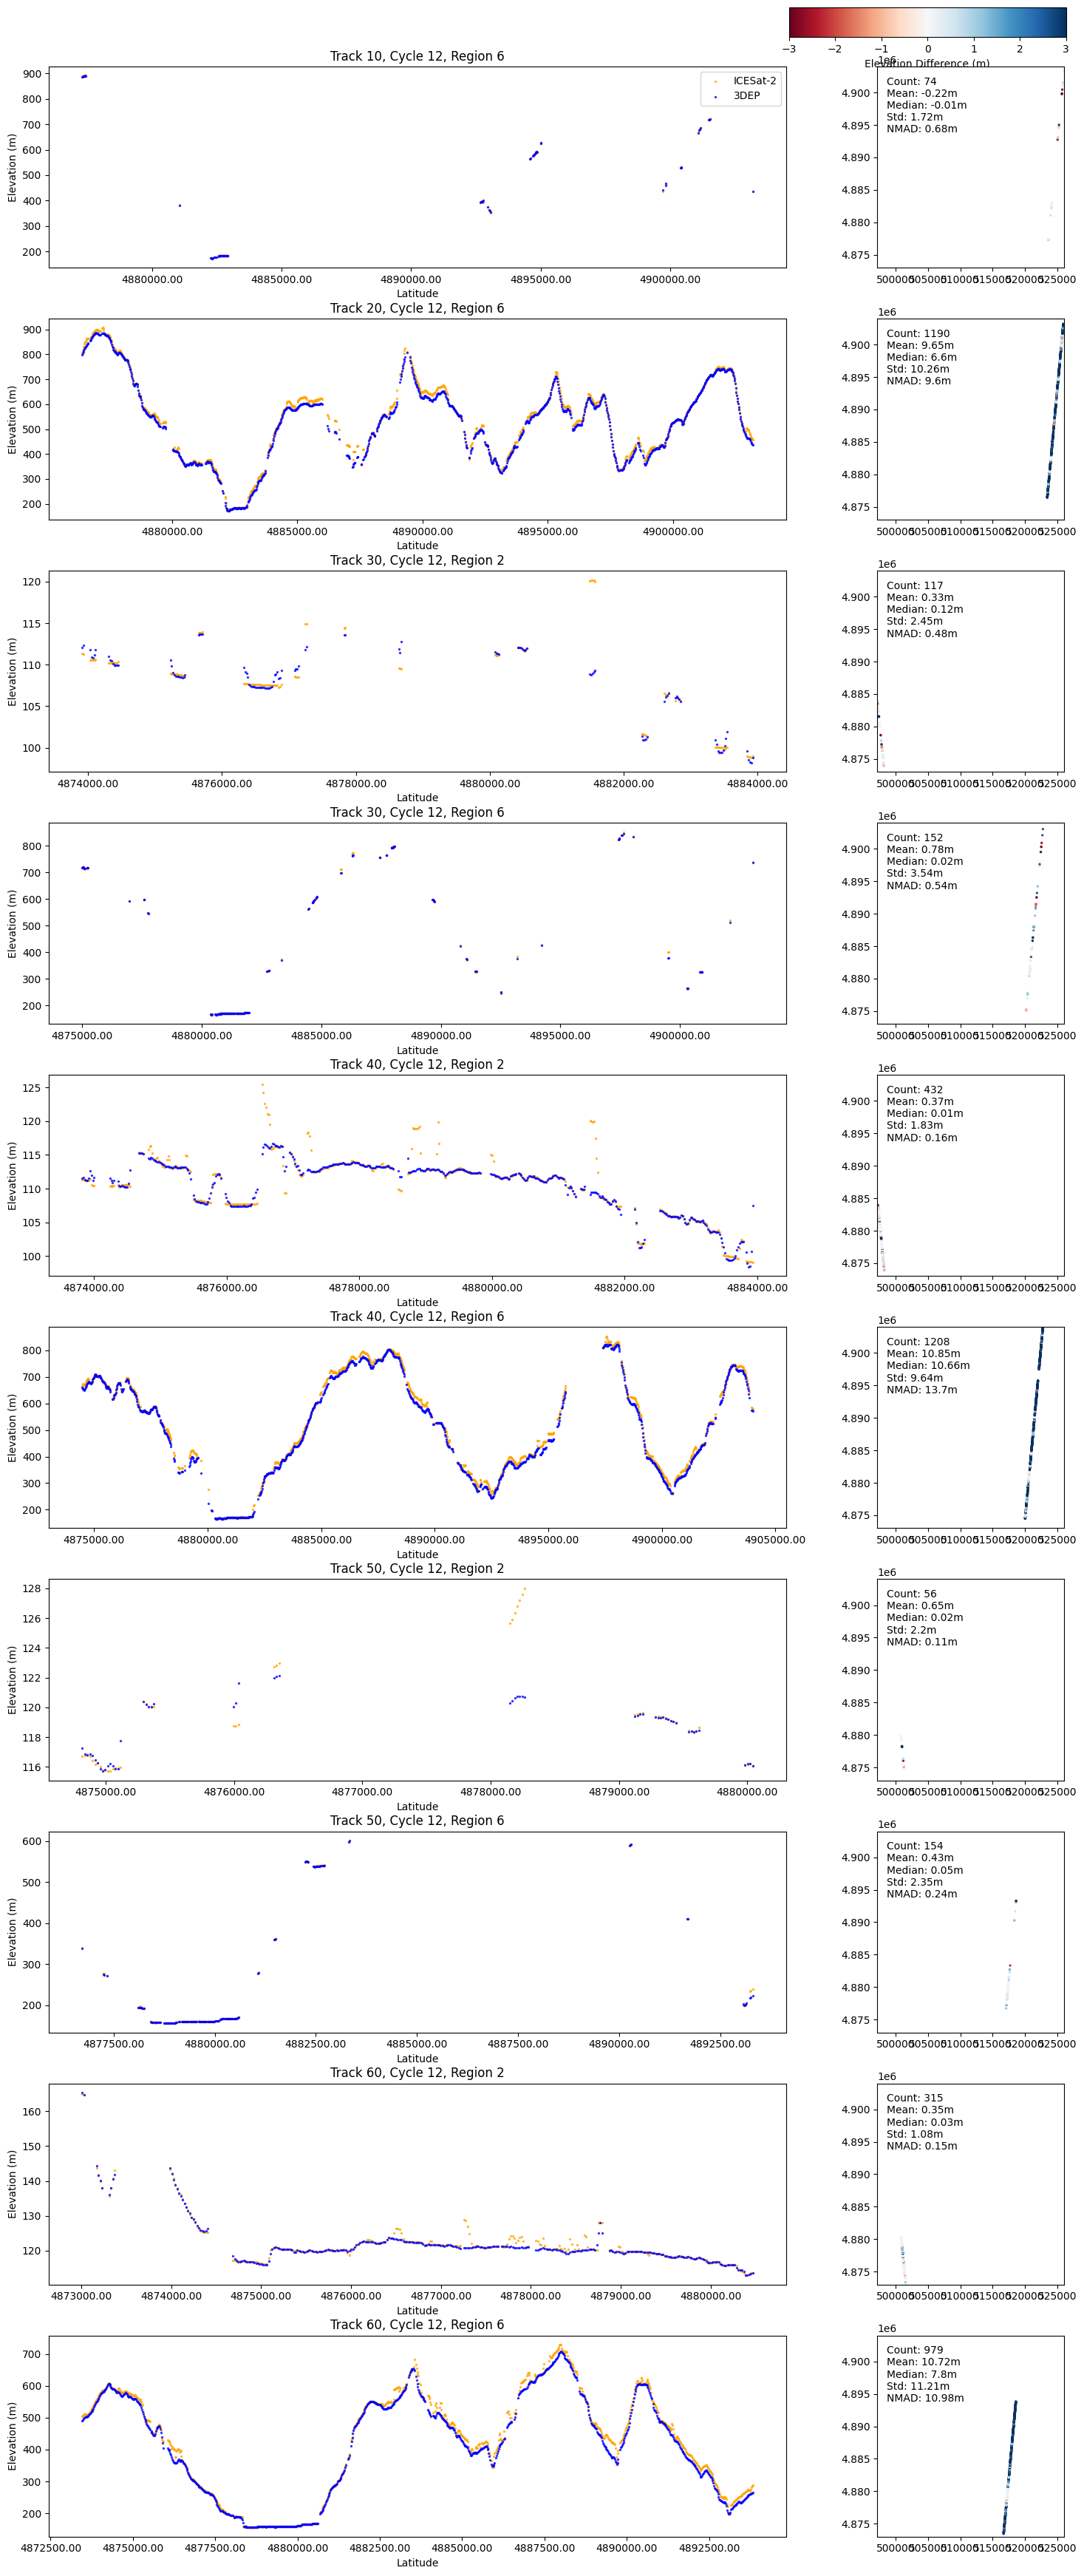

In [ ]:
# Group by track identifiers
track_groups = gf_atl06.groupby(["gt", "cycle", "region"])
n_groups = len(track_groups)

fig = plt.figure(figsize=(15, 4 * n_groups))
gs = GridSpec(n_groups, 2, width_ratios=[3, 1])  # Adjusted column widths

# Create a colorbar axis above the right column
cbar_ax = fig.add_axes([0.715, 0.86, 0.25, 0.01])  # Adjusted height for visibility
norm = plt.Normalize(vmin=-3, vmax=3)
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
plt.colorbar(sm, cax=cbar_ax, orientation="horizontal", label="Elevation Difference (m)")

# Compute overall bounds for gf_default
minx, miny, maxx, maxy = gf_atl06.total_bounds

for idx, (name, group) in enumerate(track_groups):
    # Left panel: elevation vs latitude plot
    ax1 = fig.add_subplot(gs[idx, 0])
    
    # Extract latitude from each point geometry (using the y coordinate)
    y_coords = [geom.y for geom in group.geometry]
    
    # Scatter plots for ICESat-2 elevations (h_mean) and 3DEP elevations (dem_elev)
    ax1.scatter(y_coords, group["h_mean"],
                color="orange", alpha=0.7, label="ICESat-2" if idx == 0 else "",
                s=2)
    ax1.scatter(y_coords, group["dem_elev"],
                color="blue", alpha=0.7, label="3DEP" if idx == 0 else "",
                s=2)
    
    ax1.set_xlabel("Latitude")
    ax1.set_ylabel("Elevation (m)")
    ax1.set_title(f"Track {name[0]}, Cycle {name[1]}, Region {name[2]}")
    ax1.xaxis.set_major_formatter(plt.FormatStrFormatter("%.2f"))
    
    # Only add legend to the first subplot
    if idx == 0:
        ax1.legend(loc="upper right", fontsize=10)
    
    # Right panel: map plot with elevation differences
    ax2 = fig.add_subplot(gs[idx, 1])
    #ds_dem["hillshade"].plot.imshow(ax=ax2, cmap='gray', add_colorbar=False)
    # Plot the current group by elev_diff, using a consistent colormap and value range
    group.plot(ax=ax2, column="elev_diff", cmap="RdBu",
               vmin=-3, vmax=3, alpha=0.7, markersize=2)
    
    # Add statistics text on the map
    mean_diff = round(group["elev_diff"].mean(), 2)
    median_diff = round(group["elev_diff"].median(), 2)
    std_diff = round(group["elev_diff"].std(), 2)
    # NMAD computed as 1.4826 * median absolute deviation from the median
    nmad = round(stats.median_abs_deviation(group["elev_diff"], scale="normal"),2)
    count = len(group)
    
    stats_text = (f"Count: {count}\nMean: {mean_diff}m\nMedian: {median_diff}m\n"
                  f"Std: {std_diff}m\nNMAD: {nmad}m")
    ax2.text(0.05, 0.95, stats_text,
             transform=ax2.transAxes,
             fontsize=10,
             verticalalignment="top",
             bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"))
    
    ax2.set_xlim(minx, maxx)
    ax2.set_ylim(miny, maxy)
    ax2.set_aspect('equal', adjustable='box')  # Ensure equal aspect ratio

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

fous on one beam for more landcover context

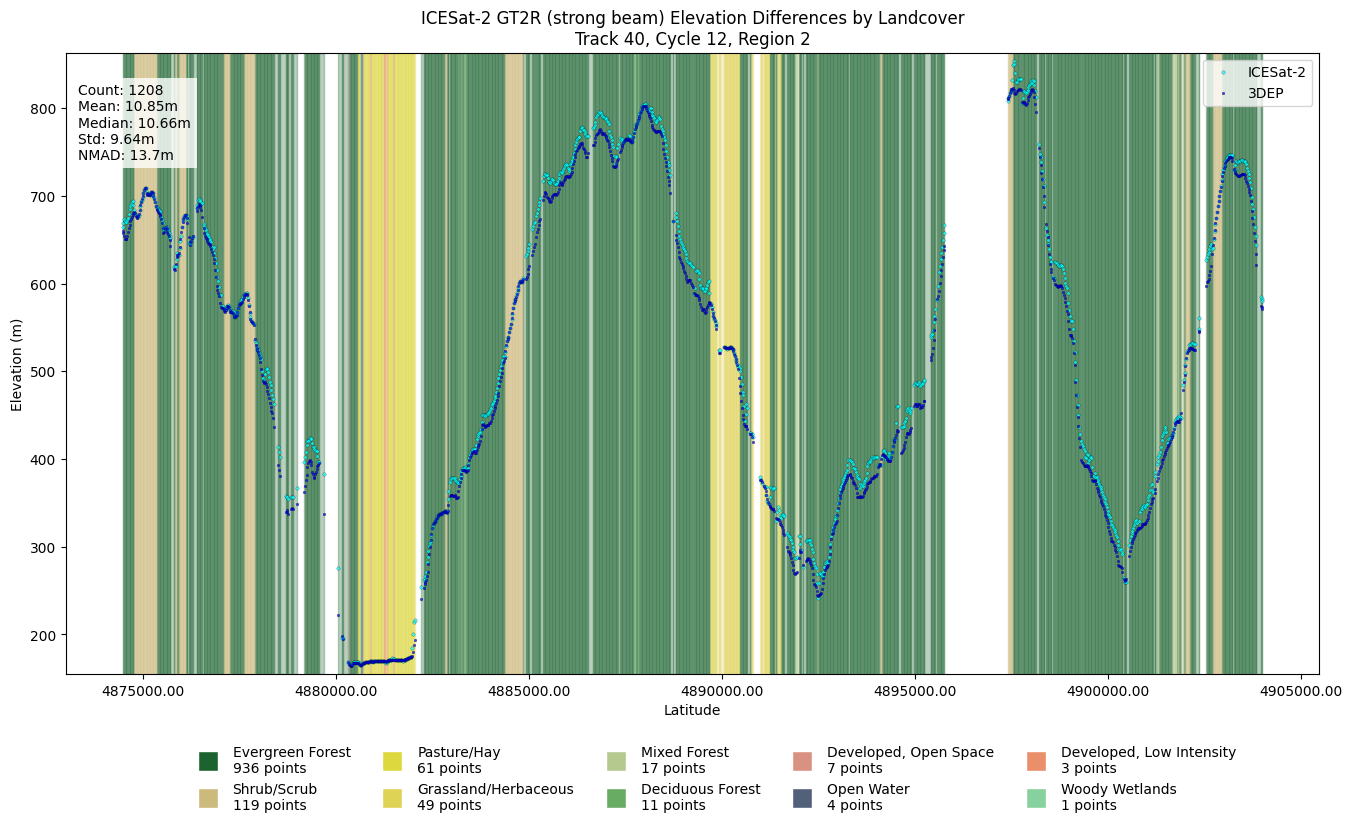

In [ ]:
group = gf_atl06[(gf_atl06['gt'] == 40) & 
                   (gf_atl06['cycle'] == 12) & 
                   (gf_atl06['region'] == 6)]
# Check if the group is empty
if group.empty:
    print("No data available for the specified track, cycle, and region.")
else:
    fig = plt.figure(figsize=(18, 8), facecolor='white')
    # Create a GridSpec with adjusted width ratios
    gs = GridSpec(1, 2, width_ratios=[3, 1])

    # Left panel: elevation vs latitude plot
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Extract latitude from each point geometry (using the y coordinate)
    y_coords = [geom.y for geom in group.geometry]
    
    # Create a DataFrame with the necessary data for easier manipulation
    plot_data = pd.DataFrame({
        'y_coord': y_coords,
        'h_mean': group['h_mean'],
        'dem_elev': group['dem_elev'],
        'nlcd_value': group['nlcd_value']
    })
    
    # Sort by y_coord (latitude) for proper filling
    plot_data = plot_data.sort_values('y_coord').reset_index(drop=True)
    
    # Get the maximum and minimum elevations for the plot limits
    max_elev = max(plot_data['h_mean'].max(), plot_data['dem_elev'].max()) + 10
    min_elev = min(plot_data['h_mean'].min(), plot_data['dem_elev'].min()) - 10
    
    # Fill background by landcover class
    # Define a threshold for maximum allowed gap between points (in degrees latitude)
    max_gap = 161  # Adjust this value based on your data spacing

    for i in range(len(plot_data) - 1):
        nlcd_value = plot_data.iloc[i]['nlcd_value']
        start_lat = plot_data.iloc[i]['y_coord']
        end_lat = plot_data.iloc[i+1]['y_coord']
        
        # Only fill if there's a valid NLCD value AND points are close enough
        if (not pd.isna(nlcd_value) and 
            nlcd_value in nlcd_colors and 
            abs(end_lat - start_lat) < max_gap):
            
            ax1.fill_betweenx([min_elev, max_elev],
                            start_lat,
                            end_lat,
                            color=nlcd_colors[nlcd_value],
                            alpha=0.3)
        
    # Scatter plots for ICESat-2 elevations (h_mean) and 3DEP elevations (dem_elev)
    ax1.scatter(y_coords, group["h_mean"],
                color="cyan", alpha=0.7, label="ICESat-2", s=6,
                edgecolor='black', linewidth=0.2)
    ax1.scatter(y_coords, group["dem_elev"],
                color="blue", alpha=0.7, label="3DEP", s=4,
                edgecolor='black', linewidth=0.2)
    
    ax1.set_xlabel("Latitude")
    ax1.set_ylabel("Elevation (m)")
    ax1.set_title(f"ICESat-2 GT2R (strong beam) Elevation Differences by Landcover\nTrack 40, Cycle 12, Region 2")
    ax1.xaxis.set_major_formatter(plt.FormatStrFormatter("%.2f"))
    ax1.legend(loc="upper right", fontsize=10)
    ax1.set_ylim(min_elev, max_elev)
    
    # Add statistics text on the map
    mean_diff = round(group["elev_diff"].mean(), 2)
    median_diff = round(group["elev_diff"].median(), 2)
    std_diff = round(group["elev_diff"].std(), 2)
    # NMAD computed as 1.4826 * median absolute deviation from the median
    nmad = round(stats.median_abs_deviation(group["elev_diff"], scale="normal"), 2)
    count = len(group)
    stats_text = (f"Count: {count}\nMean: {mean_diff}m\nMedian: {median_diff}m\n"
                  f"Std: {std_diff}m\nNMAD: {nmad}m")
    ax1.text(0.01, 0.95, stats_text,
             transform=ax1.transAxes,
             fontsize=10,
             verticalalignment="top",
             bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"))
    
    # Add a legend for NLCD classes
    unique_nlcd_values = plot_data['nlcd_value'].unique()
    
    # Count occurrences of each NLCD value (instead of area)
    nlcd_counts = plot_data['nlcd_value'].value_counts().to_dict()
    
    legend_handles = [
        mlines.Line2D([0], [0], marker='s', color='w', markerfacecolor=nlcd_colors[key], markersize=15,
                      label=f"{nlcd_labels[key]}\n{nlcd_counts.get(key, 0)} points")
        for key in sorted(unique_nlcd_values, 
                         key=lambda x: nlcd_counts.get(x, 0),
                         reverse=True)
        if key in nlcd_labels and key in nlcd_colors
    ]
    
    plt.figlegend(handles=legend_handles, bbox_to_anchor=(0.4, 0), loc='upper center', ncol=5, frameon=False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

load in our custom processing for ATL06. not a lot of comparison here since they're so similar

In [103]:
gf_custom = gpd.read_parquet("/home/jehayes/gda_final/ATL06_LaserLottery/data/OR_McKenzieRiver_1_2021_gridsearch/nlcd_30.0_10.0_5_10.0.parquet")

/tmp/ipykernel_196514/3312595844.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


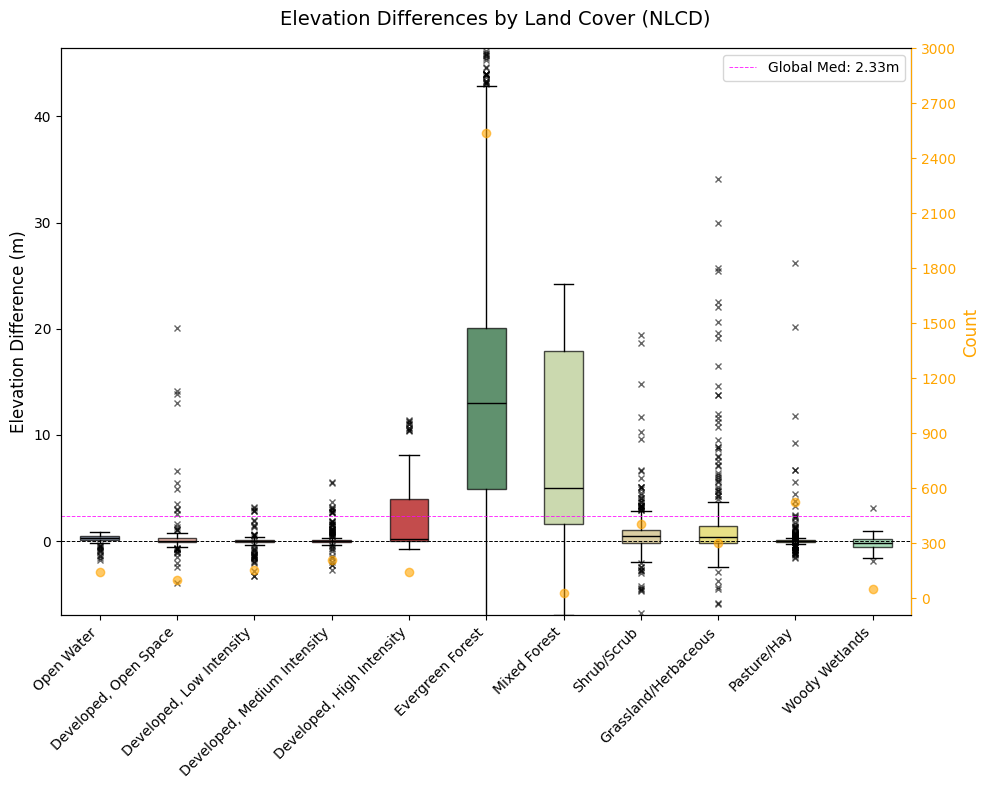

In [ ]:
fig, ax = boxplot_nlcd(gf_atl06)
plt.tight_layout()
plt.show()